In [1]:
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; } </style>"))

We have to set the variable `KMP_DUPLICATE_LIB_OK` to avoid a bug in TensorFlow.

In [2]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


# Simple Linear Regression with TensorFlow

We need to read our data from a <tt>csv</tt> file.  The module `csv` offers a number of functions for reading and writing a <tt>csv</tt> file.

In [3]:
import csv

The data we want to read is contained in the <tt>csv</tt> file `'cars.csv'`.  In this file, the first column has the *miles per gallon*, while the *engine displacement* is given in the third column.  We convert *miles per gallon* into *km per liter* (1 mile = 1.60934 kilometres, 1 gallon = 3,78541 litres)) and *cubic inches* into *liters* (1 cubic inch = 0.0163871 litres).

In [4]:
with open('cars.csv') as cars_file:
    reader       = csv.reader(cars_file, delimiter=',')
    line_count   = 0
    kpl          = []
    displacement = []
    for row in reader:
        if line_count != 0:  # skip header of file
            # miles per gallon is in first column 
            kpl         .append(float(row[0]) * 1.60934 / 3.78541) 
            # engine displacement is in third column
            displacement.append(float(row[2]) * 0.0163871)  
        line_count += 1
print(f'{line_count} lines read')

Now `kpl` is a list of floating point numbers specifying the fuel eficiency, while the list `displacement` contains the corresponding *engine displacements* measured in cubic inches.

In [5]:
kpl[:5]

The *fuel consumption* is the inverse of the variable `kpl`.  The variable `lph` gives the number of liters needed to drive 100 kilometres.  

In [6]:
lph = [ 100 / x for x in kpl]

In [7]:
lph[:5]

[13.067503172453028,
 15.681003806943632,
 13.067503172453028,
 14.700941069009657,
 13.836179829656148]

Yes, these old American cars had a terrible fuel efficiency.  But a look at the engine displacements gives us a clue about the reason.

In [8]:
displacement[:5]

[5.0308397000000005,
 5.735485000000001,
 5.2110978,
 4.981678400000001,
 4.9489042]

The number of data pairs of the form $\langle x, y \rangle$ that we have read is stored in the variable `m`.

In [9]:
m = len(displacement)
m

392

In order to be able to plot the *fuel efficiency* versus the *engine displacement* and  we turn the lists `displacement` and `lph` into `numpy` arrays.  

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
X = np.array(displacement)

In [12]:
Y = np.array(lph)

Text(0.5, 1.0, 'fuel consumption versus engine displacement')

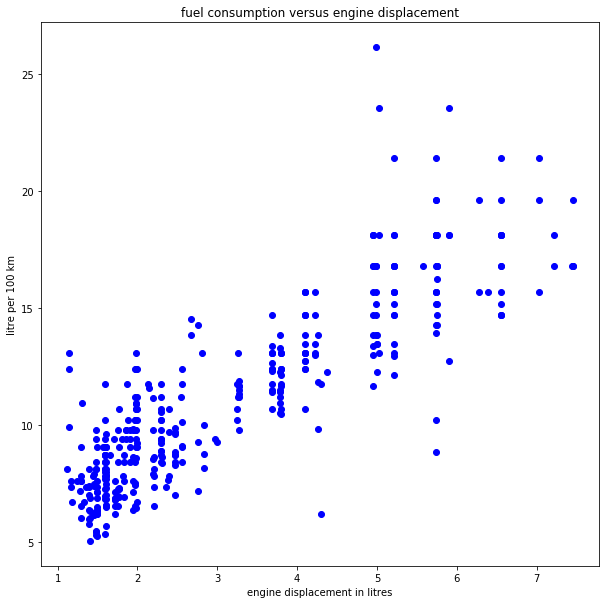

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, c='b')
plt.xlabel('engine displacement in litres')
plt.ylabel('litre per 100 km')
plt.title('fuel consumption versus engine displacement')

Next, we want to show how linear regression can be formulated as a minimization problem and how this minimization problem can be solved using TensorFlow.

In [14]:
import tensorflow as tf

We have to define `placeholders` to insert our data into TensorFlow. We define a `placeholder` for the independent variable `displacement` and a `placeholder` for the dependent variable `kpl`.  We do not want to hardwire the number of examples, hence we set the `shape` to `None`.

In [15]:
X_ph = tf.placeholder(tf.float32, shape=None)
Y_ph = tf.placeholder(tf.float32, shape=None)

We have a linear model to predict the fuel consumption from the displacement.  This linear model is as follows:
$$ Y = \vartheta \cdot X $$
Here $X$ is the engine displacement, while $Y$ is the fuel consumption.

A first guess for $\vartheta$ would be the average fuel consumption divided by the average engine displacement: 

In [16]:
theta_initial = np.mean(Y) / np.mean(X)
theta_initial

3.530787587283287

In [17]:
ϑ = tf.Variable(theta_initial, dtype=tf.float32)
Y_predicted = ϑ * X_ph

The *loss function* is defined as the sum of the squares of the errors, divided by the number of data points:

In [18]:
loss = tf.reduce_sum(tf.square(Y_predicted - Y_ph))/m
loss

<tf.Tensor 'truediv:0' shape=() dtype=float32>

After some experimentation, I have chosen a *learning rate* $\alpha$ of $0.03$:

In [19]:
α = 0.03

We will use *gradient descent* to minimize our *loss function*. 

In [20]:
optimizer = tf.train.GradientDescentOptimizer(α)
train     = optimizer.minimize(loss)

Finally, we can start a TensorFlow session and run our optimizer for 11 steps of gradient descent.

In [21]:
init = tf.global_variables_initializer()
with tf.Session() as s:
    s.run(init)
    for k in range(1, 11+1):
        data_dict = {X_ph: X, Y_ph: Y}
        s.run(train, data_dict)
        theta, l = s.run([ϑ, loss], data_dict)
        print('%2d:' % k, 'ϑ =', '%1.8f,' % theta, 'loss =', '%1.8f' % l)

 1: ϑ = 3.25728369, loss = 9.38866711
 2: ϑ = 3.19846988, loss = 9.31861973
 3: ϑ = 3.18582273, loss = 9.31538010
 4: ϑ = 3.18310332, loss = 9.31523037
 5: ϑ = 3.18251848, loss = 9.31522274
 6: ϑ = 3.18239260, loss = 9.31522179
 7: ϑ = 3.18236566, loss = 9.31522274
 8: ϑ = 3.18235970, loss = 9.31522274
 9: ϑ = 3.18235850, loss = 9.31522274
10: ϑ = 3.18235826, loss = 9.31522274
11: ϑ = 3.18235826, loss = 9.31522274


We can conclude that for a car from the early eighties that has an engine displacement of $d$ litres, the fuel consumption is about $3.18 \cdot d$ litres per 100 kilometres.